In [1]:
from astropy.table import QTable

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [2]:
master_table = QTable.read('../spirals/Pipe3D-master_file_vflag_10_smooth2-27.txt', format='ascii.ecsv')

## $V_{max}$ of best fit

In [3]:
master_table['v_max'] = -1.
master_table['v_max'].unit = 'km / s'

for i in range(len(master_table)):
    curve = master_table['curve_used'][i]
    
    if curve != 'non' and curve != 'none':
        master_table['v_max'][i] = master_table[curve + '_v_max'][i]

## Split by environment

In [4]:
vboolean = master_table['vflag'] == 1
wboolean = master_table['vflag'] == 0

void_table = master_table[vboolean]
wall_table = master_table[wboolean]
edge_table = master_table[np.logical_not(np.logical_or(vboolean, wboolean))]

## Tully-Fisher relation

<IPython.core.display.Javascript object>


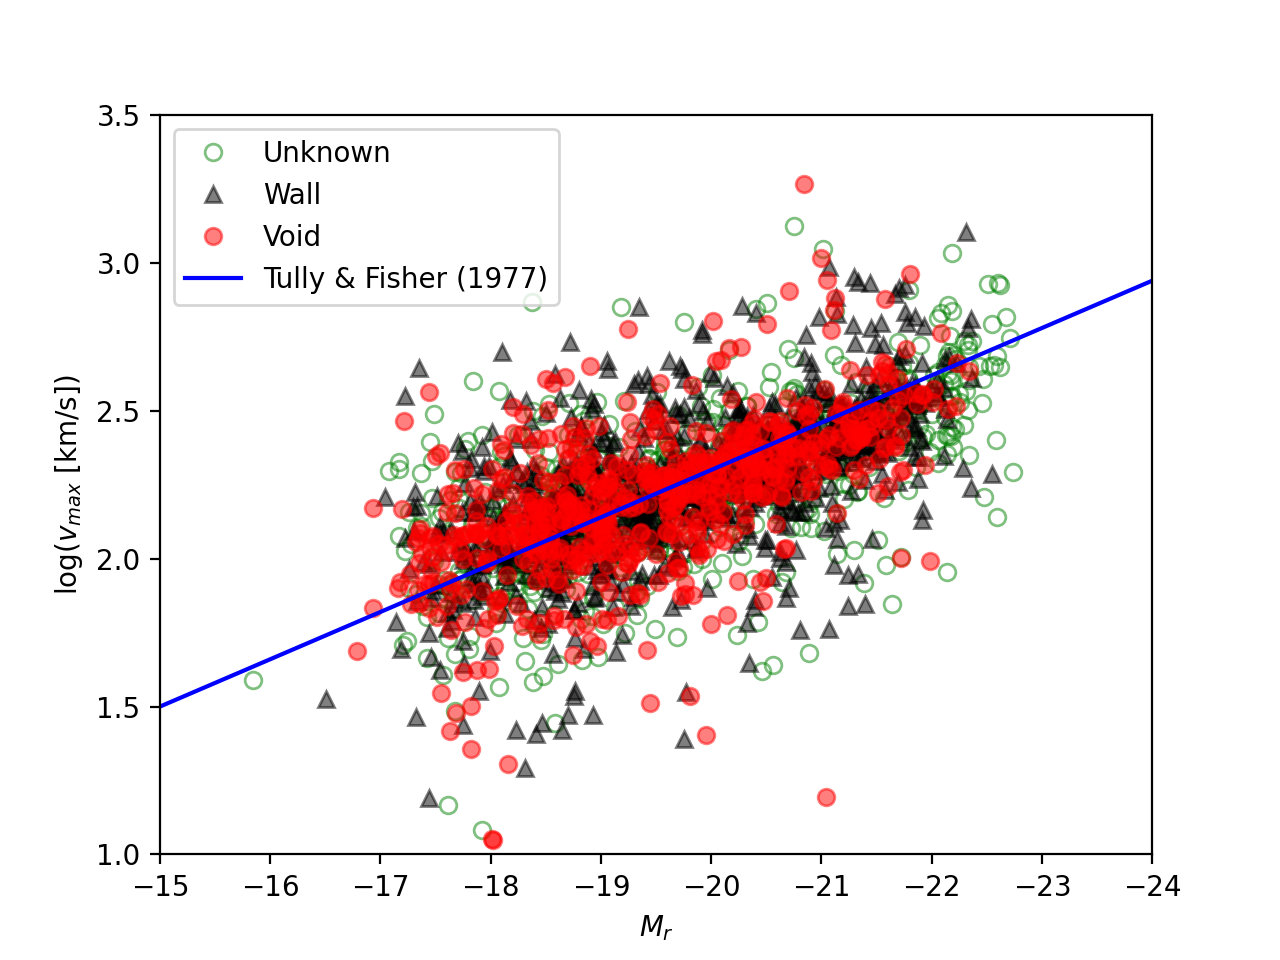

/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


In [7]:
%matplotlib notebook

plt.figure()

plt.plot(edge_table['rabsmag'], np.log10(edge_table['v_max'].data), 'go', fillstyle='none', alpha=0.5, 
         label='Unknown')
plt.plot(wall_table['rabsmag'], np.log10(wall_table['v_max'].data), 'k^', alpha=0.5, label='Wall')
plt.plot(void_table['rabsmag'], np.log10(void_table['v_max'].data), 'ro', alpha=0.5, label='Void')

Mr = np.linspace(-25,-13)
plt.plot(Mr, Mr/-6.25 - 0.9, 'b-', label='Tully & Fisher (1977)')
#plt.plot(Mr, Mr/-8.25 - 0.15, 'b-', label='Tully & Fisher (1977)')

plt.xlabel('$M_r$')
plt.ylabel('$\log(v_{max}$ [km/s])')

plt.xlim((-15,-24))
plt.ylim((1,3.5))

plt.legend();

#plt.savefig('../Images/TullyFisher.eps', format='eps', dpi=500)